<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Load-iModulons-from-Combined-data" data-toc-modified-id="Load-iModulons-from-Combined-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load iModulons from Combined data</a></span></li><li><span><a href="#Load-iModulon-Categories" data-toc-modified-id="Load-iModulon-Categories-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load iModulon Categories</a></span></li></ul></li><li><span><a href="#Create-RBH-graph" data-toc-modified-id="Create-RBH-graph-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Create RBH graph</a></span></li><li><span><a href="#Regulon-Discovery" data-toc-modified-id="Regulon-Discovery-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Regulon Discovery</a></span><ul class="toc-item"><li><span><a href="#HprR" data-toc-modified-id="HprR-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>HprR</a></span></li><li><span><a href="#Molybdenum-and-anaerobiosis" data-toc-modified-id="Molybdenum-and-anaerobiosis-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Molybdenum and anaerobiosis</a></span></li><li><span><a href="#Get-active-datasets" data-toc-modified-id="Get-active-datasets-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Get active datasets</a></span></li><li><span><a href="#RcsC-related" data-toc-modified-id="RcsC-related-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>RcsC related</a></span></li></ul></li></ul></div>

# Setup

In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import sys, os, re
from itertools import combinations
import seaborn as sns
from scipy import stats
sys.path.append('../../scripts/')
from core import *

In [2]:
sns.set_style('ticks')

In [3]:
# Use custom stylesheet for figures
plt.style.use('custom')

## Load iModulons from Combined data

In [4]:
# Thresholds were obtained from 2_identify_thresholds
cutoffs = {
 'combined': 400,
 'colombos':400}

In [5]:
class IcaData():
    def __init__(self,M,A,X,metadata,cutoff):
        self.M = pd.read_csv(M,index_col=0)
        self.M.columns = self.M.columns.astype(int)
        self.A = pd.read_csv(A,index_col=0)
        self.A.index = self.A.index.astype(int)
        self.X = pd.read_csv(X,index_col=0)
        self.metadata = pd.read_csv(metadata,index_col=0)
        self.thresholds = {k:self.get_threshold(k,cutoff) for k in self.M.columns}
    
    def show_enriched(self,k):
        gene_table = gene_info.copy()
        gene_table = gene_table.reindex(self.M.index)
        in_imod = abs(self.M[k]) > self.thresholds[k]
        weights = self.M.loc[in_imod,k]
        weights.name = 'weight'
        rows = gene_table.loc[in_imod]
        final_rows = pd.concat([weights,rows],axis=1)
        return final_rows
    
    def get_threshold(self,k,cutoff):
        i=0
        genes = abs(self.M[k]).sort_values()
        k2,p = stats.normaltest(self.M[k])
        while k2 > cutoff:
            i -= 1
            k2,p = stats.normaltest(self.M.loc[genes.index[:i],k])
        imod_genes = genes.iloc[i:]
        return np.mean([genes.iloc[i], genes.iloc[i - 1]])

def load(dataset):
    
    if dataset == 'colombos':
        ds_dir = os.path.join(DATA_DIR,'colombos')
        X_file = os.path.join(ds_dir,'colombos.csv')
        metadata_file = os.path.join(ds_dir,'metadata.csv')
    
    else:
        # Define directories
        ds_dir = os.path.join(DATA_DIR,'iModulons',dataset)
        X_file = os.path.join(DATA_DIR,'processed_data',dataset+'.csv')
        metadata_file = os.path.join(DATA_DIR,'metadata',dataset+'_metadata.csv')
    
    M_file = os.path.join(ds_dir,'M.csv')
    A_file = os.path.join(ds_dir,'A.csv')
    
    return IcaData(M_file,A_file,X_file,metadata_file,cutoffs[dataset])

In [6]:
# Load datasets
objs = {}
for ds in tqdm(['combined','colombos']):
    objs[ds] = load(ds)

In [7]:
colombos_annot = pd.read_csv(os.path.join(DATA_DIR,'colombos','categories.csv'),index_col=0)

## Load iModulon Categories

In [8]:
DF_combi_cats = pd.read_csv(os.path.join(DATA_DIR,'iModulons','categories_curated.csv'),index_col=0)
DF_combi_cats.index = DF_combi_cats.dataset.combine(DF_combi_cats.component,lambda x1,x2:x1+'_'+str(x2))
DF_combi_cats = DF_combi_cats[DF_combi_cats.dataset=='combined']

In [9]:
DF_colombos_cats = pd.read_csv(os.path.join(DATA_DIR,'colombos','categories.csv'),index_col=0)

In [10]:
counts = DF_colombos_cats.value_counts('type')

In [11]:
counts

type
regulatory         119
uncharacterized    103
biological          21
dtype: int64

([<matplotlib.patches.Wedge at 0x7f41d80b5460>,
 [Text(0.035546792401568106, 1.0994254979533449, 'regulatory'),
  Text(-0.3290805796410357, -1.0496218233740762, 'uncharacterized'),
  Text(1.0597079520712889, -0.29498992578878913, 'biological')],
 [Text(0.019389159491764417, 0.5996866352472789, '49%\n(119)'),
  Text(-0.17949849798601944, -0.5725209945676778, '42%\n(103)'),
  Text(0.578022519311612, -0.16090359588479405, '9%\n(21)')])

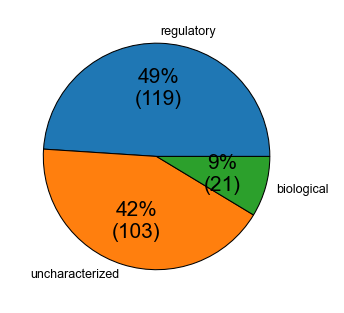

In [12]:
plt.pie(counts.values, labels=counts.index,
        autopct=lambda x: '{:.0f}%\n({:d})'.format(x,int(np.round(x*sum(counts)/100))))

In [13]:
sg_imods = []
for k in objs['colombos'].M.columns:
    #if objs['colombos'].M[k].sort_values().iloc[-1] > 2*objs['colombos'].M[k].sort_values().iloc[-2]:
    if len(objs['colombos'].show_enriched(k)) == 1:
        sg_imods.append(k)

In [14]:
len(sg_imods)

23

# Create RBH graph

In [15]:
def cos_dist(s1,s2):
    return np.dot(s1.T,s2)/np.sqrt((s1**2).sum()).values.reshape(-1,1)/np.sqrt((s2**2).sum()).values.reshape(1,-1)

def rbh(s1,s2):
    dist = 1-abs(cos_dist(s1,s2))

    colmins = dist.argmin(axis=0)
    rowmins = dist.argmin(axis=1)

    res = []
    for idx1,idx2 in enumerate(rowmins):
        if colmins[idx2] == idx1:
            res.append([idx1,idx2,dist[idx1,idx2]])
    return res

In [16]:
shared_genes = objs['combined'].M.index & objs['colombos'].M.index

In [17]:
s1 = objs['combined'].M.loc[shared_genes]
s2 = objs['colombos'].M.loc[shared_genes]

In [18]:
result = rbh(objs['combined'].M.loc[shared_genes],objs['colombos'].M.loc[shared_genes])
links = pd.DataFrame(result,columns=['combined','colombos','distance'])
links = links[links.distance < 0.7]

In [19]:
for i,row in links.iterrows():
    links.loc[i,'type1'] = DF_combi_cats.loc['combined_'+str(int(row.combined)),'type']
    links.loc[i,'type2'] = DF_colombos_cats.loc['colombos_'+str(int(row.colombos)),'type']

In [20]:
links

,combined,colombos,distance,type1,type2
0,0,99,0.397851,regulatory,regulatory
1,1,158,0.536590,regulatory,regulatory
3,3,113,0.223961,regulatory,regulatory
4,5,54,0.131967,regulatory,regulatory
6,7,56,0.506486,regulatory,regulatory
...,...,...,...,...,...
124,168,121,0.584502,regulatory,regulatory
125,169,193,0.533248,uncharacterized,uncharacterized
126,171,141,0.594575,functional,biological
127,172,168,0.502374,regulatory,uncharacterized


In [21]:
from matplotlib_venn import venn2

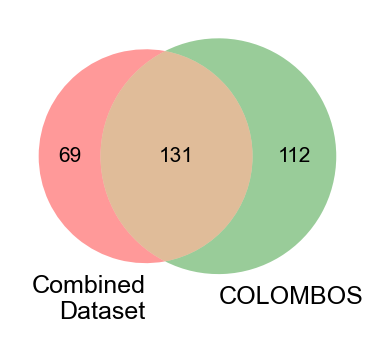

In [22]:
venn2((len(s1.columns)-len(links),len(links),len(s2.columns)-len(links)),
      set_labels=['Combined\nDataset','COLOMBOS'])

In [23]:
links[(links.type1 == 'uncharacterized') & (links.type2 == 'uncharacterized')]

,combined,colombos,distance,type1,type2
12,13,140,0.697368,uncharacterized,uncharacterized
27,35,144,0.262905,uncharacterized,uncharacterized
31,39,136,0.428663,uncharacterized,uncharacterized
35,45,201,0.422651,uncharacterized,uncharacterized
59,77,135,0.428917,uncharacterized,uncharacterized
63,82,78,0.229816,uncharacterized,uncharacterized
105,139,216,0.410615,uncharacterized,uncharacterized
125,169,193,0.533248,uncharacterized,uncharacterized


In [24]:
reg_links = links[(links.type1 == 'regulatory') & (links.type2 == 'regulatory')]

In [25]:
overlap = []
for i,row in reg_links.iterrows():
    combi_set = set(objs['combined'].show_enriched(row['combined']).index) & set(shared_genes)
    colo_set = set(objs['colombos'].show_enriched(row['colombos']).index) & set(shared_genes)
    overlap.append(len(combi_set & colo_set)/min(len(combi_set),len(colo_set)))

Text(0, 0.5, 'Number of shared iModulons')

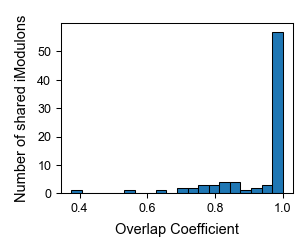

In [26]:
fig,ax = plt.subplots(figsize=(2,1.5))
plt.hist(overlap)
ax.set_xlabel('Overlap Coefficient')
ax.set_ylabel('Number of shared iModulons')

# Regulon Discovery

## HprR

In [29]:
from adjustText import adjust_text

def colombos_vs_combined(k1,k2,fig_name):

    fig,ax = plt.subplots(figsize=(1.8,1.8))

    colombos_genes = set(objs['colombos'].show_enriched(k1).index) & set(shared_genes)
    combined_genes = set(objs['combined'].show_enriched(k2).index) & set(shared_genes)
    imod_genes = colombos_genes & combined_genes
    other_genes = set(shared_genes) - colombos_genes - combined_genes
    colombos_genes = colombos_genes - imod_genes
    combined_genes = combined_genes - imod_genes

    ax.scatter(objs['colombos'].M.loc[colombos_genes,k1],objs['combined'].M.loc[colombos_genes,k2],s=10,c='red',alpha=1)
    ax.scatter(objs['colombos'].M.loc[combined_genes,k1],objs['combined'].M.loc[combined_genes,k2],s=10,c='blue',alpha=1)
    ax.scatter(objs['colombos'].M.loc[imod_genes,k1],objs['combined'].M.loc[imod_genes,k2],s=10,c='purple',alpha=1)
    ax.scatter(objs['colombos'].M.loc[other_genes,k1],objs['combined'].M.loc[other_genes,k2],s=3,c='gray',alpha=.5)
    
    texts = []
    for gene in imod_genes:
        texts.append(ax.text(objs['colombos'].M.loc[gene,k1],
                             objs['combined'].M.loc[gene,k2],
                             gene_info.loc[gene].gene_name,fontsize=6))
    adjust_text(texts,
                only_move={'objects': 'y'},
                expand_objects=(1.2, 1.4),
                expand_points=(1.3, 1.3))

    xmin,xmax = ax.get_xlim()
    ymin,ymax = ax.get_ylim()
    allmin = max(xmin,ymin)
    allmax = min(ymax,xmax)

    ax.hlines([-objs['combined'].thresholds[k2],objs['combined'].thresholds[k2]],xmin,xmax,linestyle='dashdot',linewidth=0.5)
    ax.vlines([-objs['colombos'].thresholds[k1],objs['colombos'].thresholds[k1]],ymin,ymax,linestyle='dashdot',linewidth=0.5)
    ax.hlines(0,xmin,xmax,linewidth=0.5,color='gray',zorder=-1)
    ax.vlines(0,ymin,ymax,linewidth=0.5,color='gray',zorder=-1)
    ax.plot([allmin,allmax],[allmin,allmax],linewidth=0.5,color='gray',zorder=-1)
    ax.set_xlim([xmin,xmax])
    ax.set_ylim([ymin,ymax])

    # for gene in ytf_genes

    ax.set_xlabel('iModulon Gene Weights (COLOMBOS)')
    ax.set_ylabel('iModulon Gene Weights (Combined)')

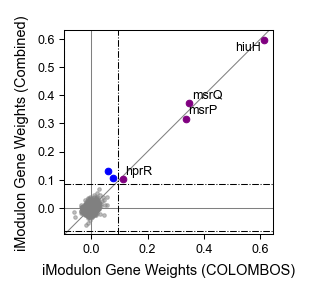

In [30]:
colombos_vs_combined(144,35,'hprR_genes.pdf')

In [31]:
objs['combined'].show_enriched(35)

,weight,gene_name,product,start,stop,strand,operon,length,cog
b1968,0.104690,hprS,sensory histidine kinase HprS - phosphorylated...,2036794,2038152,-,hprR;hprS,1359,Signal transduction mechanisms
b1969,0.101613,hprR,phosphorylated DNA-binding transcriptional dua...,2038152,2038823,-,hprR;hprS,672,Signal transduction mechanisms
b1970,0.597583,hiuH,hydroxyisourate hydrolase / transthyretin-rela...,2038956,2039369,+,hiuH,414,Function unknown
b1971,0.316853,msrP,periplasmic protein-L-methionine sulfoxide red...,2039478,2040482,+,msrQ;msrP,1005,Function unknown
b1972,0.373916,msrQ,periplasmic protein-L-methionine sulfoxide red...,2040483,2041118,+,msrQ;msrP,636,Inorganic ion transport and metabolism
b1973,0.129842,zinT,metal-binding protein ZinT,2041375,2042025,+,zinT,651,Function unknown


In [32]:
hpr_A = objs['colombos'].A.loc[[144]].T.sort_values(by=144)
hpr_A['condition'] = hpr_A.index.str.replace(r'_\d$','')
hpr_A.tail(20)

,144,condition
test_GSE33147_lac2_day20_0,6.906912,test_GSE33147_lac2_day20
test_GSE1121_anaerobic_arcA_2,7.003533,test_GSE1121_anaerobic_arcA
test_GSE33147_lacC_day20_2,7.135317,test_GSE33147_lacC_day20
test_GSE33147_lac2_day60_2,7.626852,test_GSE33147_lac2_day60
test_GSE1121_anaerobic_oxyR_2,7.650094,test_GSE1121_anaerobic_oxyR
test_GSE1121_anaerobic_arcA_1,7.672996,test_GSE1121_anaerobic_arcA
test_GSE1121_anaerobic_soxS_2,7.772924,test_GSE1121_anaerobic_soxS
test_GSE1121_anaerobic_arcA_0,7.796946,test_GSE1121_anaerobic_arcA
test_GSE1121_anaerobic_appY_0,7.934135,test_GSE1121_anaerobic_appY
test_E-MEXP-244_HOCl_1,7.980762,test_E-MEXP-244_HOCl


Text(0, 0.5, 'Putative HprR iModulon Activity')

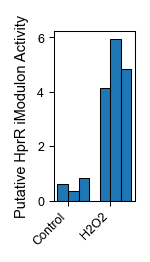

In [33]:
data = hpr_A[['GSE35371' in x for x in hpr_A.condition]].sort_index()
data = data.iloc[[3,4,5,0,1,2]]
fig,ax = plt.subplots(figsize=(0.7,1.5))
ax.bar([1,1.25,1.5,2,2.25,2.5],data[144],width=0.25,align='edge')
ax.set_xticks([1.25,2.25])
xmin,xmax = ax.get_xlim()
ax.hlines(0,xmin,xmax,linewidth=0.5)
ax.set_xlim([xmin,xmax])
ax.set_xticklabels(['Control','H2O2'],rotation=45,ha='right')
ax.set_ylabel('Putative HprR iModulon Activity')

## Molybdenum and anaerobiosis

In [34]:
objs['colombos'].show_enriched(201).sort_values('weight')

,weight,gene_name,product,start,stop,strand,operon,length,cog
LocusTag,,,,,,,,,
b1755,0.099200,ynjC,putative ABC transporter membrane subunit YnjC,1837212.0,1838747.0,+,ynjD;ynjC;ynjB;ynjA;ydjZ;ydjY;ydjX,1536.0,Function unknown
b1930,0.099794,yedF,putative sulfurtransferase YedF,2009479.0,2009712.0,+,yedF;yedE,234.0,"Posttranslational modification, protein turnov..."
b4334,0.124445,yjiL,"putative ATPase, activator of (R)-hydroxygluta...",4563922.0,4564689.0,-,yjiM;yjiL,768.0,Lipid transport and metabolism
b1929,0.129651,yedE,putative selenium transporter YedE,2008277.0,2009482.0,+,yedF;yedE,1206.0,Function unknown
b1754,0.146007,ynjB,putative ABC transporter periplasmic binding p...,1836073.0,1837239.0,+,ynjD;ynjC;ynjB;ynjA;ydjZ;ydjY;ydjX,1167.0,Function unknown
b1753,0.152114,ynjA,AhpD-like domain-containing protein YnjA,1835515.0,1836063.0,+,ynjD;ynjC;ynjB;ynjA;ydjZ;ydjY;ydjX,549.0,Function unknown
b4335,0.198170,yjiM,putative dehydratase subunit,4564699.0,4565850.0,-,yjiM;yjiL,1152.0,Amino acid transport and metabolism
b1752,0.220087,ydjZ,DedA family protein YdjZ,1834808.0,1835515.0,+,ynjD;ynjC;ynjB;ynjA;ydjZ;ydjY;ydjX,708.0,Function unknown
b1757,0.228422,ynjE,molybdopterin synthase sulfurtransferase,1839467.0,1840774.0,+,ynjE,1308.0,Inorganic ion transport and metabolism


In [35]:
objs['combined'].show_enriched(45).sort_values('weight')

,weight,gene_name,product,start,stop,strand,operon,length,cog
b3894,-0.107015,fdoG,formate dehydrogenase O subunit &alpha;,4082772,4085822,-,fdhE;fdoI;fdoH;fdoG,3051,Energy production and conversion
b1756,0.087075,ynjD,putative ABC transporter ATP-binding protein YnjD,1838747,1839400,+,ynjD;ynjC;ynjB;ynjA;ydjZ;ydjY;ydjX,654,Function unknown
b3151,0.092770,yraQ,permease family protein YraQ,3297098,3298138,-,yraQ,1041,Function unknown
b3020,0.127752,ygiS,putative deoxycholate binding periplasmic protein,3166111,3167718,-,ygiS,1608,Amino acid transport and metabolism
b1755,0.136453,ynjC,putative ABC transporter membrane subunit YnjC,1837212,1838747,+,ynjD;ynjC;ynjB;ynjA;ydjZ;ydjY;ydjX,1536,Function unknown
b1754,0.160635,ynjB,putative ABC transporter periplasmic binding p...,1836073,1837239,+,ynjD;ynjC;ynjB;ynjA;ydjZ;ydjY;ydjX,1167,Function unknown
b1753,0.162348,ynjA,AhpD-like domain-containing protein YnjA,1835515,1836063,+,ynjD;ynjC;ynjB;ynjA;ydjZ;ydjY;ydjX,549,Function unknown
b4334,0.204659,yjiL,"putative ATPase, activator of (R)-hydroxygluta...",4563922,4564689,-,yjiM;yjiL,768,Lipid transport and metabolism
b1930,0.212584,yedF,putative sulfurtransferase YedF,2009479,2009712,+,yedF;yedE,234,"Posttranslational modification, protein turnov..."
b1757,0.214151,ynjE,molybdopterin synthase sulfurtransferase,1839467,1840774,+,ynjE,1308,Inorganic ion transport and metabolism


In [36]:
ytf_genes = objs['colombos'].show_enriched(201).index & objs['combined'].show_enriched(45).index
gene_info.loc[ytf_genes]

,gene_name,product,start,stop,strand,operon,length,cog
b1750,ydjX,DedA family protein YdjX,1833401,1834111,+,ynjD;ynjC;ynjB;ynjA;ydjZ;ydjY;ydjX,711,Function unknown
b1751,ydjY,4Fe-4S ferredoxin-type domain-containing prote...,1834116,1834793,+,ynjD;ynjC;ynjB;ynjA;ydjZ;ydjY;ydjX,678,Function unknown
b1752,ydjZ,DedA family protein YdjZ,1834808,1835515,+,ynjD;ynjC;ynjB;ynjA;ydjZ;ydjY;ydjX,708,Function unknown
b1753,ynjA,AhpD-like domain-containing protein YnjA,1835515,1836063,+,ynjD;ynjC;ynjB;ynjA;ydjZ;ydjY;ydjX,549,Function unknown
b1754,ynjB,putative ABC transporter periplasmic binding p...,1836073,1837239,+,ynjD;ynjC;ynjB;ynjA;ydjZ;ydjY;ydjX,1167,Function unknown
b1755,ynjC,putative ABC transporter membrane subunit YnjC,1837212,1838747,+,ynjD;ynjC;ynjB;ynjA;ydjZ;ydjY;ydjX,1536,Function unknown
b1757,ynjE,molybdopterin synthase sulfurtransferase,1839467,1840774,+,ynjE,1308,Inorganic ion transport and metabolism
b1929,yedE,putative selenium transporter YedE,2008277,2009482,+,yedF;yedE,1206,Function unknown
b1930,yedF,putative sulfurtransferase YedF,2009479,2009712,+,yedF;yedE,234,"Posttranslational modification, protein turnov..."
b4334,yjiL,"putative ATPase, activator of (R)-hydroxygluta...",4563922,4564689,-,yjiM;yjiL,768,Lipid transport and metabolism


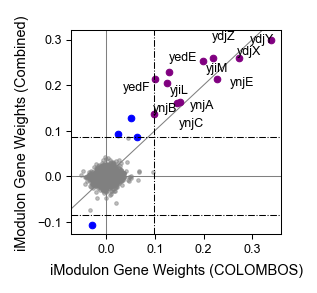

In [37]:
colombos_vs_combined(201,45,'ytf_genes.pdf')

In [38]:
ytf_A = objs['colombos'].A.loc[[201]].T.sort_values(by=201)
ytf_A['condition'] = ytf_A.index.str.replace(r'_\d$','')
ytf_A.tail()

,201,condition
test_GSE42205_ethanol_20%_t3_1,7.153811,test_GSE42205_ethanol_20%_t3
test_GSE4569_1h_UV_2,7.181728,test_GSE4569_1h_UV
test_GSE21839_WT_-O2_2,7.965607,test_GSE21839_WT_-O2
test_GSE21839_WT_-O2_1,8.096041,test_GSE21839_WT_-O2
test_GSE21839_WT_-O2_0,8.107451,test_GSE21839_WT_-O2


## Get active datasets

Text(0, 0.5, 'iModulon Activity')

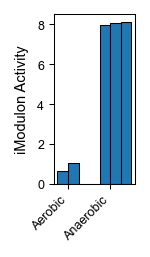

In [39]:
data = ytf_A[['GSE21839' in x for x in ytf_A.condition]].iloc[[3,4,8,9,10]]
fig,ax = plt.subplots(figsize=(0.7,1.5))
ax.bar([1,1.25,2,2.25,2.5],data[201],width=0.25,align='edge')
ax.set_xticks([1.25,2.25])
xmin,xmax = ax.get_xlim()
ax.hlines(0,xmin,xmax,linewidth=0.5)
ax.set_xlim([xmin,xmax])
ax.set_xticklabels(['Aerobic','Anaerobic'],rotation=45,ha='right')
plt.ylabel('iModulon Activity')

Text(0, 0.5, 'iModulon Activity')

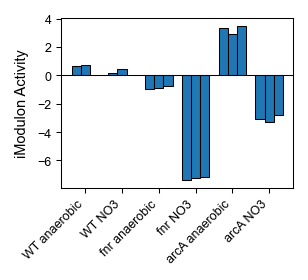

In [40]:
gse55365 = ytf_A[['GSE55365' in x for x in ytf_A.condition]].sort_index()
gse55365 = gse55365.iloc[[14,15,6,7,11,12,13,3,4,5,8,9,10,0,1,2]]

fig,ax = plt.subplots(figsize=(2,1.5))
ax.bar([1, 1.25, 2, 2.25, 3, 3.25, 3.5, 4,4.25,4.5,5,5.25,5.5,6,6.25,6.5],gse55365[201],width=0.25,align='edge')
ax.set_xticks(.375+np.arange(1,7))
ax.set_xticklabels(['WT anaerobic','WT NO3','fnr anaerobic','fnr NO3','arcA anaerobic','arcA NO3'],rotation=45,ha='right')
xmin,xmax = ax.get_xlim()
ax.hlines(0,xmin,xmax,linewidth=0.5)
ax.set_xlim([xmin,xmax])
plt.ylabel('iModulon Activity')

## RcsC related

In [41]:
objs['colombos'].show_enriched(216).sort_values('weight')

,weight,gene_name,product,start,stop,strand,operon,length,cog
LocusTag,,,,,,,,,
b2086,0.062657,yegS,lipid kinase YegS,2168712.0,2169611.0,+,yegS,900.0,Lipid transport and metabolism
b2943,0.064581,galP,galactose:H<sup>+</sup> symporter,3088284.0,3089678.0,+,galP,1395.0,Carbohydrate transport and metabolism
b3552,0.074004,yiaD,PF13488 family lipoprotein YiaD,3716547.0,3717206.0,+,yiaD,660.0,Cell wall/membrane/envelope biogenesis
b1743,0.074850,spy,ATP-independent periplasmic chaperone,1825140.0,1825625.0,-,spy,486.0,Cell motility
b1236,0.076535,galU,UTP&mdash;glucose-1-phosphate uridylyltransferase,1291457.0,1292365.0,+,galU,909.0,Cell wall/membrane/envelope biogenesis
b1482,0.082201,osmC,osmotically inducible peroxiredoxin OsmC,1556625.0,1557056.0,+,osmC,432.0,"Posttranslational modification, protein turnov..."
b2936,0.087568,loiP,metalloprotease LoiP,3081913.0,3082671.0,+,loiP,759.0,"Posttranslational modification, protein turnov..."
b2833,0.091395,ygdR,DUF903 domain-containing lipoprotein YgdR,2971271.0,2971489.0,+,ygdR,219.0,Function unknown
b4376,0.098848,osmY,periplasmic chaperone OsmY,4611396.0,4612001.0,+,osmY,606.0,Function unknown


In [42]:
objs['combined'].show_enriched(139).sort_values('weight')

,weight,gene_name,product,start,stop,strand,operon,length,cog
b0099,-0.066645,mutT,8-oxo-dGTP diphosphatase,111044,111433,+,mutT;secA;secM,390,"Replication, recombination and repair"
b2809,0.065953,ygdI,DUF903 domain-containing lipoprotein YgdI,2942918,2943145,-,ygdI,228,Function unknown
b4026,0.066097,yjbE,uncharacterized protein YjbE,4235906,4236148,+,yjbH;yjbG;yjbF;yjbE,243,No COG Annotation
b2670,0.072752,alaE,G7399-MONOMER,2799164,2799613,+,alaE,450,"Intracellular trafficking, secretion, and vesi..."
b2943,0.073274,galP,galactose:H<sup>+</sup> symporter,3088284,3089678,+,galP,1395,Carbohydrate transport and metabolism
b2018,0.075042,hisL,<i>his</i> operon leader peptide,2089996,2090046,+,hisL;hisG;hisD;hisC;hisB;hisH;hisA;hisF;hisI,51,No COG Annotation
b2936,0.080052,loiP,metalloprotease LoiP,3081913,3082671,+,loiP,759,"Posttranslational modification, protein turnov..."
b0439,0.090645,lon,Lon protease,458888,461242,+,lon;clpX,2355,"Posttranslational modification, protein turnov..."
b2833,0.097022,ygdR,DUF903 domain-containing lipoprotein YgdR,2971271,2971489,+,ygdR,219,Function unknown
b3552,0.110061,yiaD,PF13488 family lipoprotein YiaD,3716547,3717206,+,yiaD,660,Cell wall/membrane/envelope biogenesis


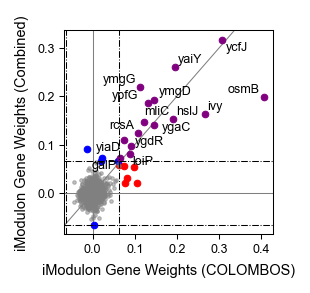

In [43]:
colombos_vs_combined(216,139,'rcs_genes.pdf')

In [44]:
rcs_A = objs['colombos'].A.loc[[216]].T.sort_values(by=216)
rcs_A['condition'] = rcs_A.index.str.replace(r'_\d$','')
rcs_A.tail(20)

,216,condition
test_GSE31140_polymyxinB_20m_2,7.936890,test_GSE31140_polymyxinB_20m
test_GSE37026_MG1655_treated_with_30ng/ml_colicin_M_30min_0,7.987839,test_GSE37026_MG1655_treated_with_30ng/ml_coli...
test_GSE10158_cefmec10_45min_0,8.246228,test_GSE10158_cefmec10_45min
test_GSE31333_-phdR_MMace_1,8.644981,test_GSE31333_-phdR_MMace
test_GSE30345_pgi_ala_0,8.679019,test_GSE30345_pgi_ala
test_GSE30345_pgi_ala_1,9.369189,test_GSE30345_pgi_ala
test_GSE11052_exp_3,10.005382,test_GSE11052_exp
test_GSE11052_exp_0,11.145050,test_GSE11052_exp
test_GSE17465_t2_2,11.501089,test_GSE17465_t2
test_GSE17465_t2_0,11.590438,test_GSE17465_t2


Text(0, 0.5, 'iModulon Activity')

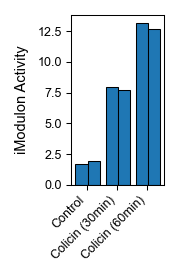

In [45]:
GSE37026 = rcs_A[['GSE37026' in x for x in rcs_A.condition]].sort_index()

fig,ax = plt.subplots(figsize=(0.8,1.5))
ax.bar([1, 1.4, 2, 2.4, 3, 3.4],GSE37026[216],width=0.4,align='edge')
ax.set_xticks(.375+np.arange(1,4))
ax.set_xticklabels(['Control','Colicin (30min)','Colicin (60min)'],rotation=45,ha='right')
xmin,xmax = ax.get_xlim()
ax.hlines(0,xmin,xmax,linewidth=0.5)
ax.set_xlim([xmin,xmax])
plt.ylabel('iModulon Activity')

Text(0, 0.5, 'iModulon Activity')

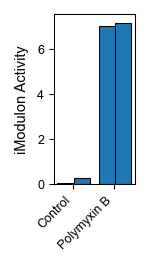

In [46]:
data = rcs_A[['GSE31140' in x for x in rcs_A.condition]].sort_index().iloc[[6,7,10,11]]

fig,ax = plt.subplots(figsize=(0.7,1.5))
ax.bar([1, 1.4, 2, 2.4],data[216],width=0.4,align='edge')
ax.set_xticks(.375+np.arange(1,3))
ax.set_xticklabels(['Control','Polymyxin B'],rotation=45,ha='right')
xmin,xmax = ax.get_xlim()
ax.hlines(0,xmin,xmax,linewidth=0.5)
ax.set_xlim([xmin,xmax])
plt.ylabel('iModulon Activity')

In [ ]:
data = rcs_A[['GSE10158' in x and '45min' in x for x in rcs_A.condition]].sort_index()
data = data.iloc[[10,11,12,13,4,5,6,7,8,9,0,1,2,3]]

fig,ax = plt.subplots(figsize=(1.5,1.5))
ax.bar([1,1.2,1.4,1.6,2,2.2,2.4,3,3.2,3.4,4,4.2,4.4,4.6],data[216],width=0.2,align='edge')
ax.set_xticks(.375+np.arange(1,5))
ax.set_xticklabels(['Control','Cefsulodin','Mecillinam','Cefsulodin/Mecillinam'],rotation=45,ha='right')
xmin,xmax = ax.get_xlim()
ax.hlines(0,xmin,xmax,linewidth=0.5)
ax.set_xlim([xmin,xmax])
plt.ylabel('iModulon Activity')

Text(0, 0.5, 'iModulon Activity')